In [130]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import svgutils.transform as sg
import sys 
import os
import math as m
#import win32com.client as win32
from scipy import integrate
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from decimal import Decimal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xlrd

In [131]:
#PARAMETERS THAT NEED TO BE MANUALLY SET
Material='W'
Motif= ''
sample= "Q294A"
FTJ = "square100-1"
Cycle_shape='Squared'
Waiting = True                     # define if there's a pause included in the file before the PUND signal
pund_1_detailed = False            # If there is data for the cycles 2 to 9

if Motif=='':
    data_folder = "/home/ngariepy/Documents/UdeS/T4/Keysight/" +str(Material)+'/'+str(sample)+'/'+str(FTJ) + '/'
else:
    data_folder = "/home/ngariepy/Documents/Udes/T4/Keysight/"+str(Material)+'/'+str(Motif)+'/'+str(sample)+'/'+str(FTJ) + '/'                                     

#d=50 #diameter in um
#S=m.pi/4*(d*1e-4)**2 #surface en cm²
t_ox= 9.4e-7 #épaisseur de HZO en cm
S = 1e-6 #surface en cm²

#Choose the cycle you want to plant by defining the Cycle_to_plot variable (also used to extract certain parameters)
Cycle_to_plot = 1e3
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
timescale = 1e6                        #define the timescale to plot (default in µs)
units = 1e6                            #define the units (default is µA)

# Gets the pulse shapes from Keysight config
with open(data_folder + "config0.json") as configf:
    config = json.load(configf)
    pentep = config["PUND_shape"]["trise"]
    palierp = config["PUND_shape"]["twidth"]
    inter = config["PUND_shape"]["tspace"]
    tpulse = 2*pentep + palierp + inter
    rise = config["aging_shape"]["trise"]
    width = config["aging_shape"]["twidth"]
    space = config["aging_shape"]["tspace"]
    Compliance = config["currentrange"]*1e-6

In [132]:
#HERE ARE DEFINED ALL THE FUNCTIONS USED IN THIS CODE
def TimeFilter (ti, tf, signal):                            #take the signal values taken between Ti and Tf
    cycle = (signal.Time >= (ti + signal.Time[0])) & (signal.Time < (tf + signal.Time[0]))
    pulse = signal[cycle]
    return pulse

def AddCycleID (CyclesList, order, nb):           #Create a list corresponding to the number of cycles done
    if order < 2 :
        CyclesList.append(10**(order))
    else :                  
        CyclesList.append(float(nb)*10**(order-1))
    return CyclesList

def isworking (values):
    Tolerance = 1.12 # tolerance if there's an unexpected peak of current 
    check = False
    if values.Voltage.empty == False:
        ToBeChecked = TimeFilter(inter, inter + 2*pentep, values)   #remove the discharge current that can induce false wrongs
        if ToBeChecked.Voltage.empty == False:                     #check if the sequence wasn't stopped manually
            if (max(abs(ToBeChecked.Current))) < (Compliance * Tolerance) :        #check if there's no electrical breakdown
                check = True
    return check

def SplitCurrent (values, P, U, N, D, PN, UD):
    a=['']
    b=['']
    P.append(TimeFilter(0, tpulse, values))
    U.append(TimeFilter(tpulse, 2*tpulse, values))
    N.append(TimeFilter(2*tpulse, 3*tpulse, values))
    D.append(TimeFilter(3*tpulse, 4*tpulse, values))
    a[0]=pd.concat([P[-1],N[-1]],axis=0)
    b[0]=pd.concat([U[-1],D[-1]],axis=0)
    PN.append(a[0])
    UD.append(b[0])
    PN[-1] = PN[-1].reset_index()
    UD[-1] = UD[-1].reset_index()
    P[-1] = P[-1].reset_index()
    U[-1] = U[-1].reset_index()
    N[-1] = N[-1].reset_index()
    D[-1] = D[-1].reset_index()
    return P, U, N, D, PN, UD
    
def getTime (index, Ferro, nonFerro, nb):
    t = []
    instant = 0
    last = Ferro.Time[0]
    for i in [Ferro, nonFerro]:
        if i is Ferro:
            instant += i.Time[0]-last
        else:
            instant += i.Time[0]- tpulse -last
        t.append(instant*nb)
        for j in range(1, len(i)):
            instant += i.Time[j]-i.Time[j-1]
            t.append(instant*nb)
        last = i['Time'].iloc[-1]
    return t

def getPUND (pos, neg, nb, status):
    if status == False : 
        pause = 0      
    else:
        pause = inter
        
    Ipos1 = TimeFilter(pause, pentep+pause, pos).Current.values
    Ipos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Current.values
    Ipos = np.append(Ipos1,Ipos2)
    Vpos1 = TimeFilter(pause, pause+pentep, pos).Voltage.values
    Vpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Voltage.values
    Vpos = np.append(Vpos1,Vpos2)
    #Vpos = np.delete(Vpos, 0)
    tpos1 = TimeFilter(pause, pentep+pause, pos).Time.values
    tpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Time.values-palierp
    tpos = np.append(tpos1, tpos2)
    
    Ineg1 = TimeFilter(pause, pentep+pause, neg).Current.values
    Ineg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Current.values
    Ineg = np.append(Ineg1,Ineg2)
    Vneg1 = TimeFilter(pause, pentep+pause, neg).Voltage.values
    Vneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Voltage.values
    Vneg = np.append(Vneg1,Vneg2)
    #Vneg = np.delete(Vneg, 0)
    tneg1 = TimeFilter(pause, pentep+pause, neg).Time.values
    tneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Time.values-palierp
    tneg = np.append(tneg1, tneg2)
    
    #Ppos = integrate.cumulative_trapezoid(Ipos, tpos) * nb * 1e6/S
    #Pneg = integrate.cumulative_trapezoid(Ineg, tneg) * nb * 1e6/S
    Ppos = integrate.cumulative_trapezoid(nb * Ipos, tpos, initial=0) * 1e6/S
    Pneg = integrate.cumulative_trapezoid(nb * Ineg, tneg, initial=0) * 1e6/S
    Prpos = Ppos[-1]                                                              
    Prneg = Pneg[-1]
    c1 = Ppos[-1]/2
    c2 = Pneg[-1]/2
    return Ppos-c1, Pneg-c2, Prpos-c1, Prneg-c2, Vpos, Vneg

def the_equalizer (arrays):
    lengths = list()
    for x in range (len(arrays)) :
        lengths.append(len(arrays[x]))
    for x in range (len(arrays)) :
        arrays[x] = arrays[x][:min(lengths)]
    return arrays

def rescale (pos, neg, pr):
    if pos[-1] >= neg[0]:
        t = pos[-1] - neg[0] - abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg + t
        pr = pr + t
    else:
        t = neg[0] - pos[-1] + abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg - t
        pr = pr-t
    return neg, pr

def get_Ec (polar, tension):
    X=[]
    Y=[]
    i=1
    X.append(tension[0])
    if polar[0]>0:
        Y.append(-polar[0])
    else:
        Y.append(polar[0])
    while abs(tension[i])>=abs(tension[i-1]):
        X.append(tension[i])
        if polar[0]>0:
            Y.append(-polar[i])
        else:
            Y.append(polar[i])
        i+=1
    Ec = np.interp(0, Y, X)
    return Ec

def get_leakage (current_pos, current_neg, nb, status):
    leak_pos_signal = [] 
    leak_neg_signal = [] 
    
    if status == False : 
        pause = 0
    else:
        pause = inter
    if palierp!=0:
        leak_pos_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_pos).Current.values
        leak_neg_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_neg).Current.values
        leakage_pos = sum(leak_pos_signal) / len(leak_pos_signal)
        leakage_neg = sum(leak_neg_signal) / len(leak_neg_signal)
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    else:
        leak_pos_signal = TimeFilter(pause, pause+pentep, current_pos).Current.values
        leak_neg_signal = TimeFilter(pause, pause+pentep, current_neg).Current.values
        leakage_pos = leak_pos_signal[-1]
        leakage_neg = leak_neg_signal[-1]
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    return leakage_pos*nb, leakage_neg*nb, density_pos, density_neg

def create_cycle (MaxV, MinV):
    if Cycle_shape == 'Squared':
        stepsT = [0, rise, width, rise, space, rise, width, rise, space]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    elif Cycle_shape == 'Triangle':
        stepsT = [0, pentep, pentep, inter, pentep, pentep, inter]
        tension = [0, MaxV, 0, 0, MinV, 0, 0]
    else:
        stepsT = [0, pentep, palierp, pentep, inter, pentep, palierp, pentep, inter]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    j=0
    time=[]
    for  i in stepsT:
        j+=i*timescale
        time.append(j)
        
    for x in time:
        x *= timescale 
        
    return time, tension 

def round_x (n, x):
    if n<0:
        return m.floor(n / float(x)) * x
    else:
        return m.ceil(n / float(x)) * x

In [133]:
#OPEN ALL THE VALID FILES AND CREATE LISTS CONTAINING ALL THE CURRENTS MEASURED DURING THE PUND
x = 0                   
j = 0
CyclesID = []
P_current = []
U_current = []
N_current = []
D_current = []
PN_current = []
UD_current = []

from subprocess import call
file = data_folder + "PUND_Data.xlsx"
wb = pd.ExcelFile(file)
nbdatas = len(wb.sheet_names) #Calculate the number of sheets in the file
Current = ['']*nbdatas #Create an array corresponding to the number of runs
print('*' + file + " opened")

for sheet in wb.sheet_names:
    Current[0] = pd.read_excel(wb, sheet)
    SplitCurrent(Current[0], P_current, U_current, N_current, D_current, PN_current, UD_current)        #Add the corresponding lines to both ON and OFF list of currents
    if isworking(P_current[-1]) & isworking(U_current[-1]) & isworking(N_current[-1]) & isworking(D_current[-1]):
        decade = int(sheet[5]) # First number after "PUND_"
        number = int(sheet[6:]) # Last one or two numbers
        AddCycleID(CyclesID, decade, number)
    else:
        print("#" + len(CyclesID) + " Cycle " + str(CyclesID[-1]) + " not valid")
        CyclesID = CyclesID[:-1]
        P_current = P_current[:-1]
        U_current = U_current[:-1]
        N_current = N_current[:-1]
        D_current = D_current[:-1]
        PN_current = PN_current[:-1]
        UD_current = UD_current[:-1]

Index = CyclesID.index(Cycle_to_plot)
Vmax = float("{:.1f}".format(float(max(PN_current[Index].Voltage))))
Vmin = float("{:.1f}".format(float(min(PN_current[Index].Voltage))))

*/home/ngariepy/Documents/UdeS/T4/Keysight/W/Q294A/square100-1/PUND_Data.xlsx opened


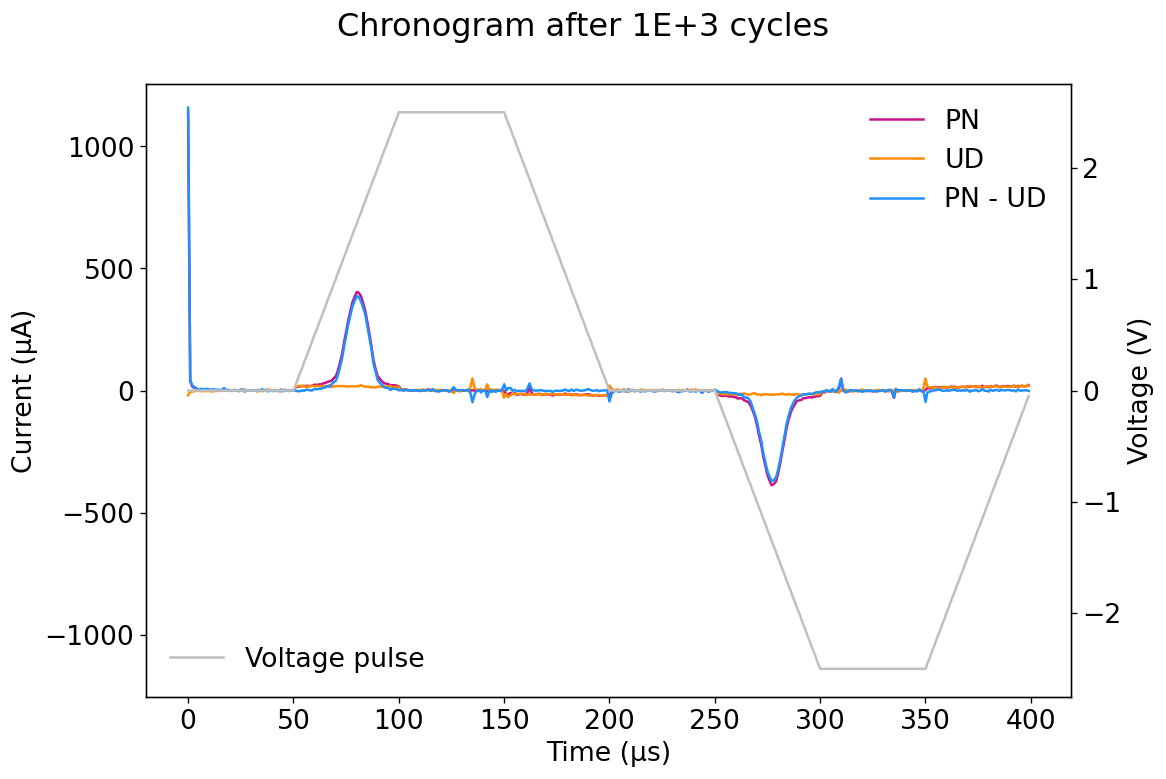

In [134]:
#PLOT THE CHRONOGRAM WITH TIME AS X SCALE

a = "{:.0E}".format(Decimal(Cycle_to_plot))
timer0 = getTime(Index, P_current[Index], N_current[Index], timescale)          #the timescale isn't the same between each segment
timer1 = getTime(Index, U_current[Index], D_current[Index], timescale)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('Chronogram at pristine state')
    else:
        abis = float(a)
        fig.suptitle('Chronogram after '  + str(int(abis)) + ' cycles')
else:
    fig.suptitle('Chronogram after '  + a + ' cycles')

ax1 = fig.add_subplot(111)

ax1.plot(timer0,PN_current[Index].Current*units*f, "mediumvioletred", label = 'PN')
ax1.plot(timer1,UD_current[Index].Current*units*f, "darkorange", label = 'UD')
plt.plot(timer0,(PN_current[Index].Current-UD_current[Index].Current)*units*f, "dodgerblue", label = 'PN - UD')
ax1.set_ylabel('Current (µA)')
ax1.set_xlabel('Time (µs)')
#ax1.set_ylim([-1000,1000])
ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
plt.legend(loc="upper right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(timer0,PN_current[Index].Voltage, 'silver', label = 'Voltage pulse')
ax2.set_ylabel('Voltage (V)')
plt.legend(loc="lower left", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'chronogram at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

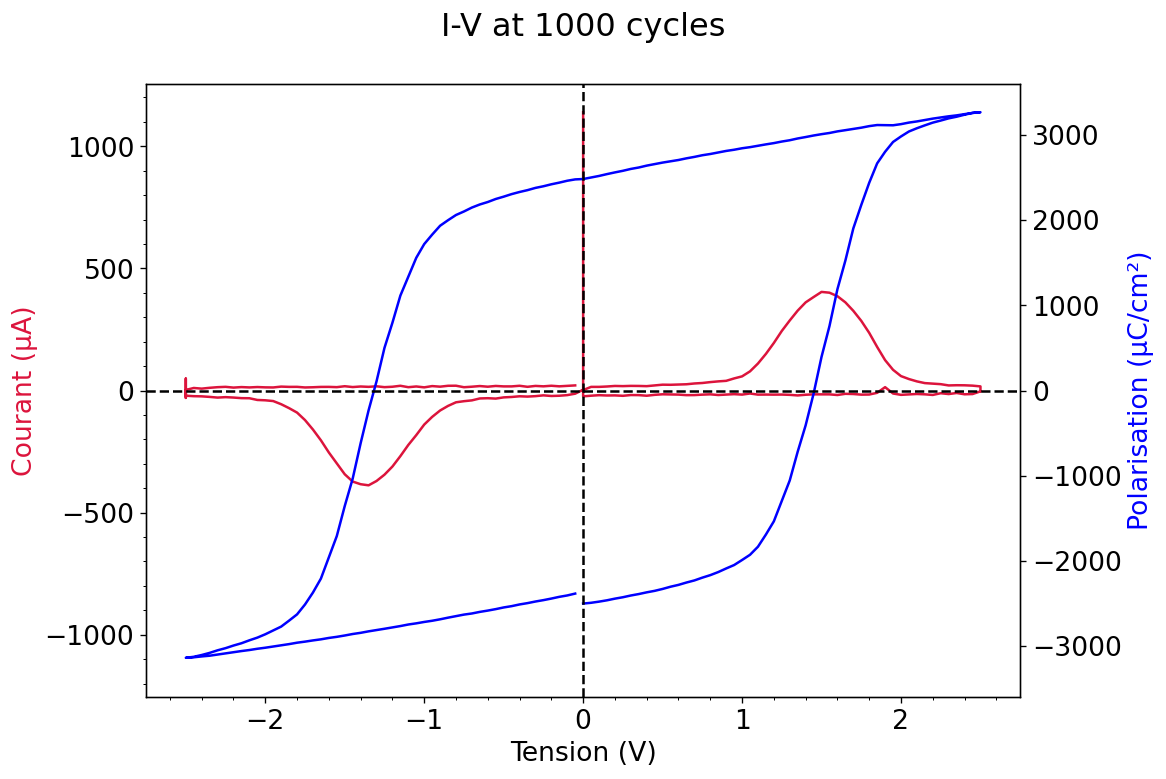

In [135]:
#SAME WITH VOLTAGE AS X SCALE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[Index], N_current[Index], f, Waiting)
P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[Index], D_current[Index], f, Waiting)
#print(len(P_pos),len(P_up),len(V_pos),len(V_up))
#print(len(P_neg),len(P_down),len(V_neg),len(V_down))
[P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
[P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
P_down, Pr_down = rescale(P_up, P_down, Pr_down)
Ppn = np.concatenate([P_pos,P_neg], axis=0)
Ppund = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
Vpund = np.concatenate([V_pos,V_neg], axis=0)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('I-V at pristine state')
    else:
        abis = float(a)
        fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
else:
    abis = float(a)
    fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(PN_current[Index].Voltage,PN_current[Index].Current*units*f, "crimson")
#ax1.plot(UD_current[Index].Voltage,abs(UD_current[Index].Current*units*f), "darkorange", label = 'UD')
#plt.plot(PN_current[Index].Voltage,abs((PN_current[Index].Current-UD_current[Index].Current)*units*f), "dodgerblue", label = 'PN - UD')
ax1.minorticks_on()
#ax1.tick_params(axis='y', which='minor', left=False)
ax1.set_ylabel('Courant (µA)', color = 'crimson')
ax1.set_xlabel('Tension (V)')
#ax1.set_yscale('log')
ax1.set_ylim([-1.1*units*max(abs(min(PN_current[Index].Current)),max(PN_current[Index].Current)),1.1*units*max(abs(min(PN_current[Index].Current)),max(PN_current[Index].Current))])       #change the sign of the limits depending of the setup

ax2 = ax1.twinx()
ax2.plot(Vpund, Ppn, "blue")
ax2.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax2.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'blue')

plt.axvline(x=0, ls='--', color='black')
plt.axhline(y=0, ls='--', color='black')
#plt.legend(loc="lower right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'P-V at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

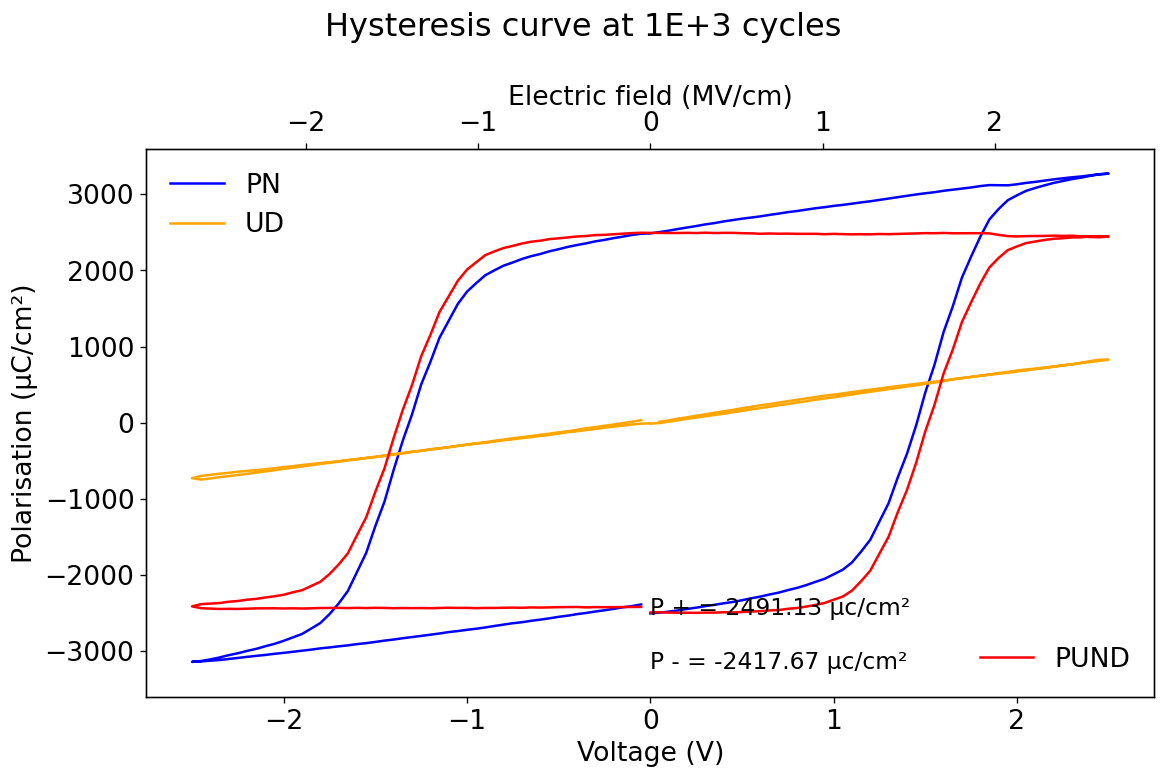

In [136]:
#PLOT THE HYSTERESIS CURVE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = 1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
    
plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Hysteresis curve at '  + a + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(Vpund, Ppn, "blue", label = 'PN')
ax1.plot(V_up, P_up, "orange", label = 'UD')
ax1.plot(V_down, P_down, "orange")
#ax1.set_xlim([-4,4])
ax1.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax1.set_ylabel('Polarisation (µC/cm\u00b2)')
ax1.set_xlabel('Voltage (V)')
plt.legend(loc="upper left", frameon = False)

ax2 = ax1.twiny()
ax2.plot(Vpund*1e-6/t_ox, Ppund, "red", label = 'PUND')
ax2.set_xlabel('Electric field (MV/cm)')
#ax2.set_xlim([-4,4])
xlim = (ax2, [-4*1e-6/t_ox, 4*1e-6/t_ox])
plt.legend(loc="lower right", frameon = False)
plt.text(0.5, 0.15, "P + = {:04.2f} µc/cm\u00b2" .format(Pr_pos-Pr_up),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)
plt.text(0.5, 0.05, "P - = {:04.2f} µc/cm\u00b2" .format(Pr_neg-Pr_down),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'PUND hysteresis at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

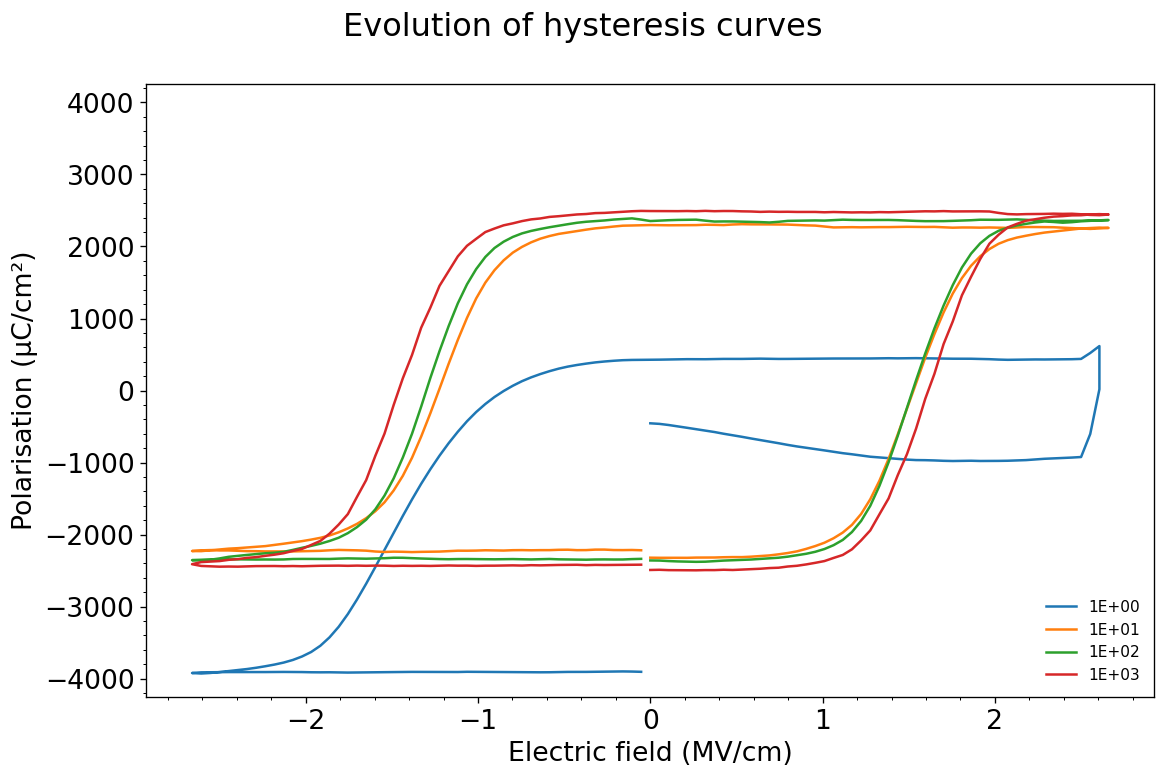

In [137]:
#PLOT THE EVOLUTION OF HYSTERESIS CURVES
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of hysteresis curves')

Pr_plus = []
Pr_minus = []
Ppund = []
Ppund_pos = []
Ppund_neg = []
Epund = []
Epund_pos = []
Epund_neg = []
Ec_pos = []
Ec_neg = []
leak_pos = []
leak_neg = []
leakd_pos = []
leakd_neg = []
x=0

#CyclesID = CyclesID[:-1]  
for i in range(0,len(CyclesID)):
    P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[i], N_current[i], f, Waiting)
    P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[i], D_current[i], f, Waiting)
    [P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
    [P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
    P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
    P_down, Pr_down = rescale(P_up, P_down, Pr_down)
    A = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
    Ppund.append(A)                                               #save the entire hysteresis
    Ppund_pos.append(P_pos-P_up)                 #save the positive and negative part of the hysteresis separately
    Ppund_neg.append(P_neg-P_down)
    B = np.concatenate([V_pos*1e-6/t_ox,V_neg*1e-6/t_ox], axis=0)
    Epund.append(B)
    Epund_pos.append(V_pos*1e-6/t_ox)
    Epund_neg.append(V_neg*1e-6/t_ox)
    Pr_plus.append(Pr_pos-Pr_up)                          #save the remanent polarisation values by taking the last value of each half hysteresis
    Pr_minus.append(Pr_neg-Pr_down)
    Ec_pos.append(get_Ec(Ppund_pos[i], Epund_pos[i]))      #save the coercive field
    Ec_neg.append(get_Ec(Ppund_neg[i], Epund_neg[i]))
    
    leak_p, leak_n,leakd_p, leakd_n = get_leakage (P_current[i], N_current[i], f, Waiting)
    leak_pos.append(leak_p)
    leak_neg.append(leak_n)
    leakd_pos.append(leakd_p)
    leakd_neg.append(leakd_n)
    
    if CyclesID[i]==1 or CyclesID[i] == 10**x or i == len(CyclesID)-1: #or i % 9 == 4:
        ID = '%.0E' % Decimal(CyclesID[i])
        plt.plot(B, A, label=str(ID))
        x+=1

scale_factor = 1.1
ymin, ymax = plt.ylim()
if abs(ymin) >= abs(ymax):
    plt.ylim([round_x(ymin, 5), -round_x(ymin, 5)])
else:
    plt.ylim([-round_x(ymax, 5), round_x(ymax, 5)])
#plt.ylim([-25,25])
plt.xlabel('Electric field (MV/cm)')
plt.minorticks_on()
plt.ylabel('Polarisation (µC/cm\u00b2)')
plt.legend(loc="lower right", frameon = False, fontsize = 'xx-small')

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'evolution_of_PUND_hysteresis.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_16683/3292085729.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


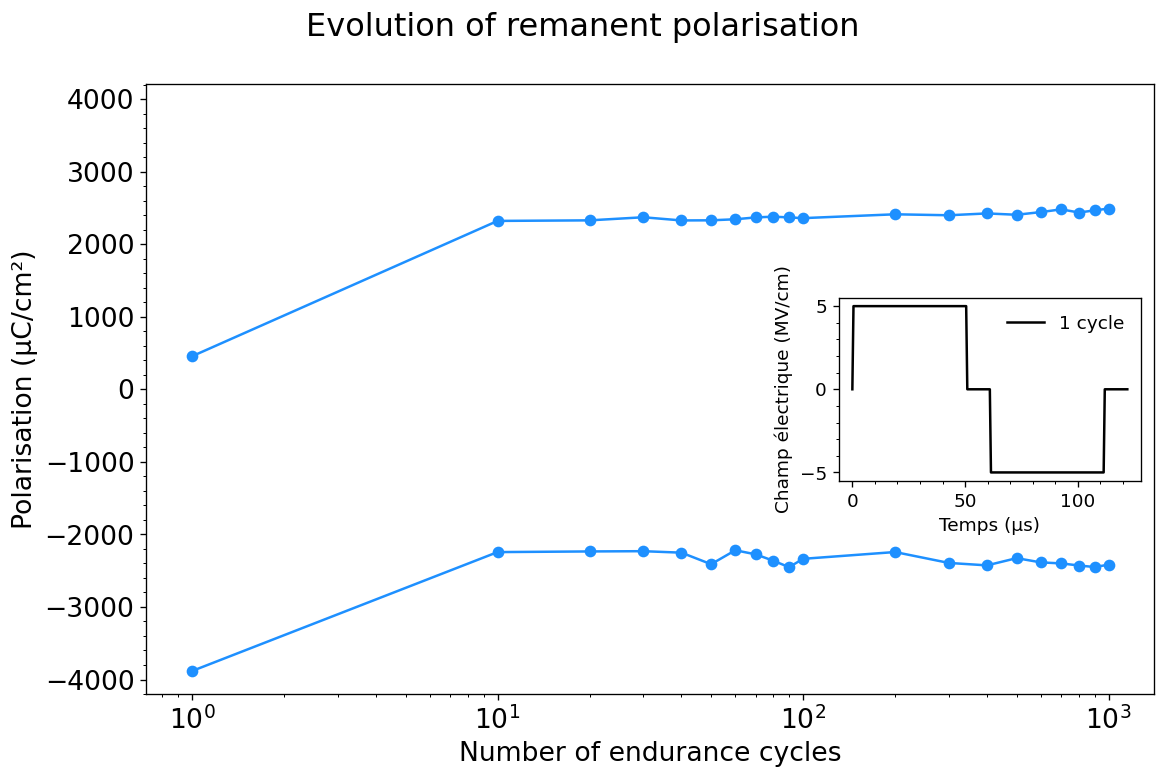

In [138]:
## plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)
ax = fig.add_subplot(111)
fig.suptitle('Evolution of remanent polarisation')

# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(ax, width="30%", height="30%", loc='center right')
#CyclesID = CyclesID[:-1]
ax.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue')
ax.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')

ax.set_xscale("log")
ax.set_xlabel('Number of endurance cycles')
ax.set_ylabel('Polarisation (µC/cm\u00b2)')
scale_factor = 1.1
ymin, ymax = ax.get_ylim()
if abs(ymin) >= abs(ymax):
    ax.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])
#ax.set_ylim([-22,22])
ax.minorticks_on()
#ax.legend(loc="best" , frameon=False)

Time, Efield = create_cycle(Vmax*2, Vmin*2)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Champ électrique (MV/cm)', fontsize='x-small')
ymin2, ymax2 = axins.get_ylim()
if abs(ymin2) >= abs(ymax2):
    axins.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    axins.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='x-small')

plt.tight_layout()
#plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_Pr.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_16683/848170356.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


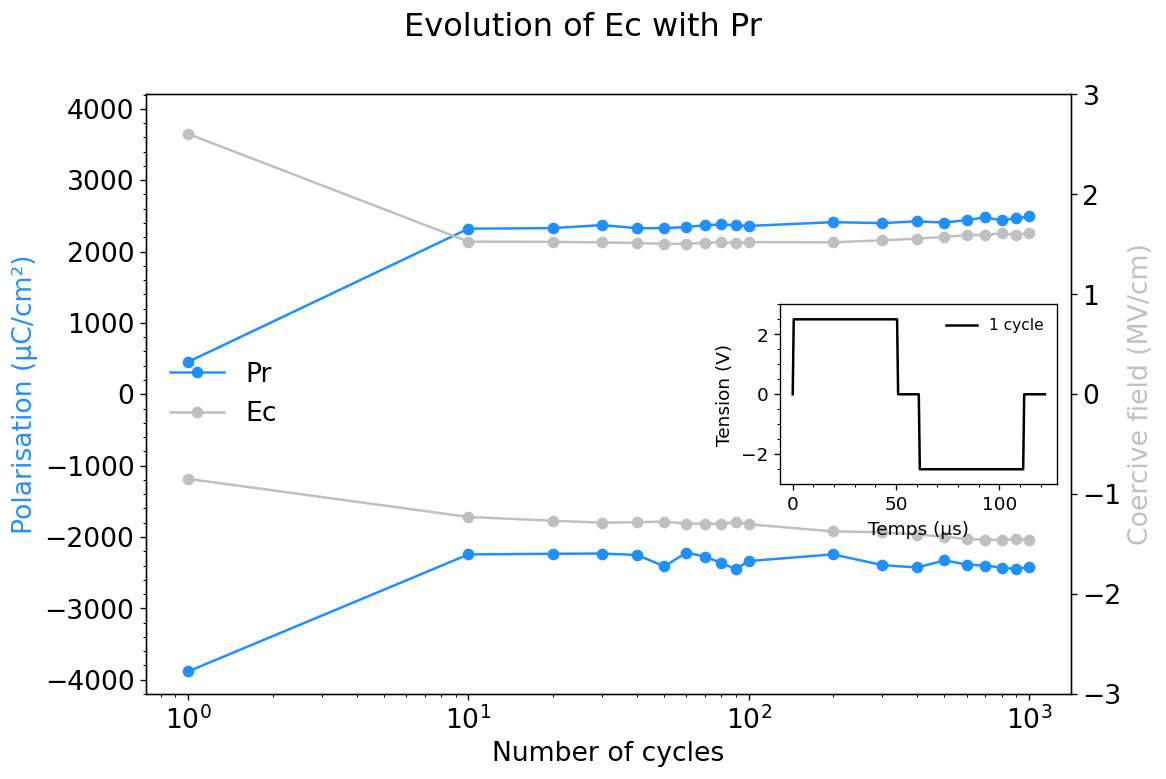

In [139]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of Ec with Pr')

ax1 = fig.add_subplot(111)

ax1.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue', label = 'Pr')
ax1.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')
ax1.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ax1.minorticks_on()
ymin, ymax = ax1.get_ylim()
if abs(ymin) >= abs(ymax):
    ax1.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax1.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])      #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(CyclesID, Ec_pos, 'o-',color = 'silver', label = 'Ec')
ax2.plot(CyclesID, Ec_neg, 'o-',color = 'silver')
ax2.set_ylabel('Coercive field (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
if abs(ymin2) >= abs(ymax2):
    ax2.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    ax2.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc='center left', frameon= False)

axins = inset_axes(ax2, width="30%", height="30%", loc='center right')
Time, Efield = create_cycle(Vmax, Vmin)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Tension (V)', fontsize='x-small')
ymin3, ymax3 = axins.get_ylim()
if abs(ymin3) >= abs(ymax3):
    axins.set_ylim([round_x(ymin3, 0.5), -round_x(ymin3, 0.5)])
else:
    axins.set_ylim([-round_x(ymax3, 0.5), round_x(ymax3, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='xx-small')

#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_Ec_with_Pr.png'), bbox_inches='tight') #saves the figure in .png

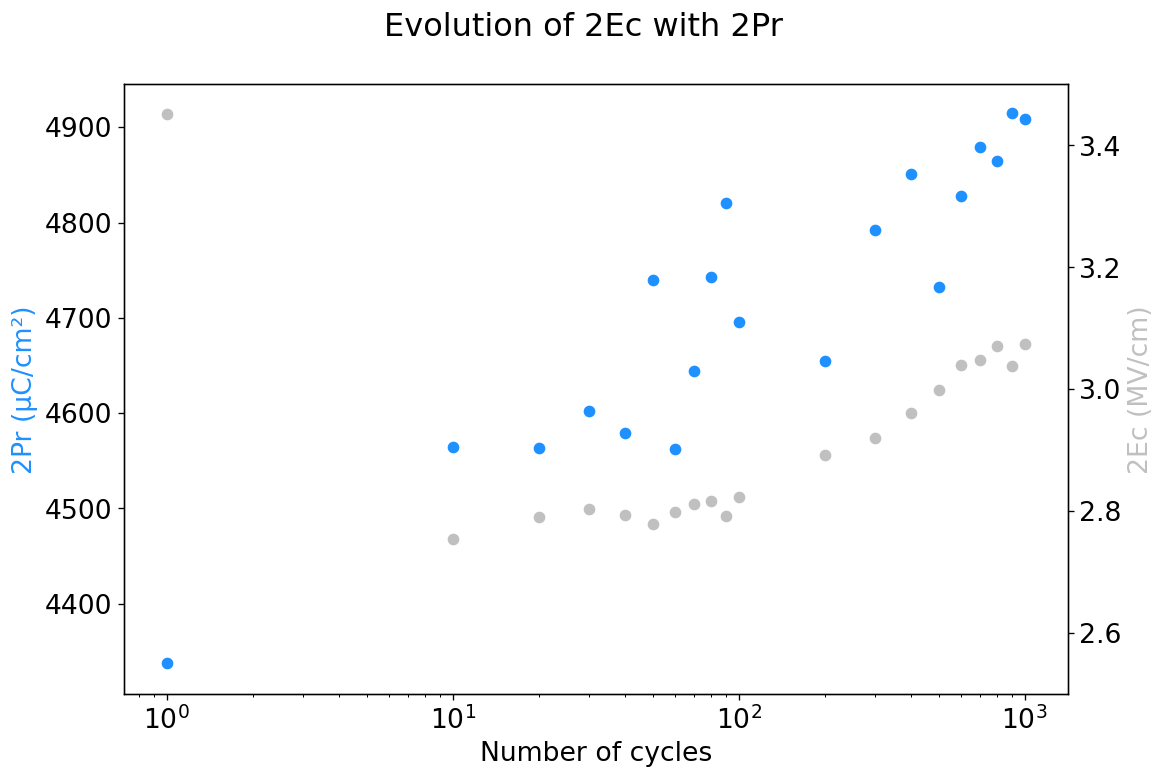

In [140]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of 2Ec with 2Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], Ec_pos[i]-Ec_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([round_x(ymin, 5)-5, round_x(ymax, 5)])
#ax1.set_ylim([30,50])
#ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('2Ec (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim([round_x(ymin2, 0.5)-0.5, round_x(ymax2, 0.5)])
#ax2.set_ylim([2, 3.5])
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_2Ec_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

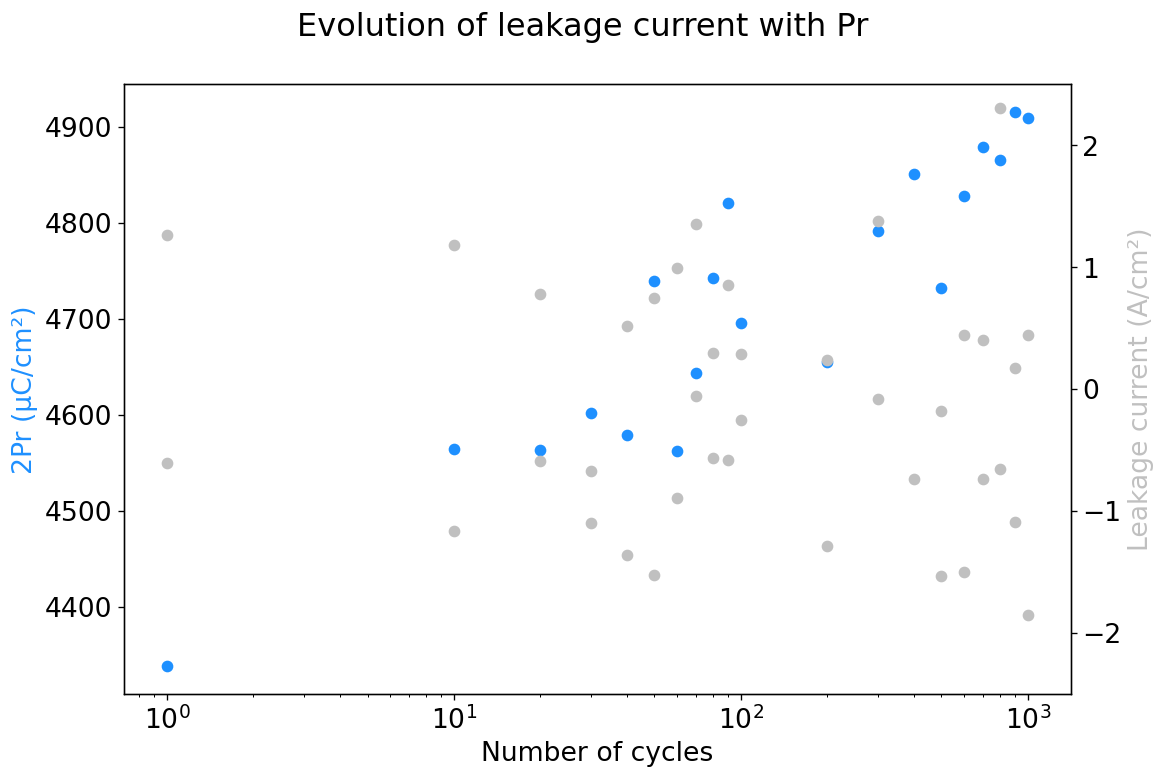

In [141]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of leakage current with Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], leakd_pos[i], 'o-',color = 'silver')
    ax2.plot(CyclesID[i], leakd_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
#lim = max(Pr_plus)+max(Pr_minus)
#ax1.set_ylim([0 ,round_x(lim, 5)])
#ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('Leakage current (A/cm\u00b2)', color = 'silver')
lim2 = max(max(leakd_pos), -min(leakd_neg))
ax2.set_ylim([round_x(-lim2, 0.5), round_x(lim2, 0.5)])
#ax2.set_yscale("log")
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_leakage current_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

In [142]:
##Save ferroelectric properties and the hysteresis of each cycle in xls files
Pr = [m - n for m,n in zip(Pr_plus,Pr_minus)]
Ec = [y - z for y,z in zip(Ec_pos,Ec_neg)]

d= {'CyclesID': CyclesID, 'Pr_plus': Pr_plus, 'Pr_minus': Pr_minus, '2Pr': Pr, 'Ec_pos': Ec_pos, 'Ec_neg': Ec_neg, '2Ec': Ec, 'Leakage_pos': leak_pos,'Leakage_neg': leak_neg,'Leakage_density_pos': leakd_pos,'Leakage_density_neg': leakd_neg}
df = pd.DataFrame(data=d)
df.to_csv(data_folder + ('Ferroelectric properties per cycle.csv'), index=False, sep='\t')

print(str(sample)+'-'+str(FTJ)+'\nProperties saved')

datas = {'Electric field (MV/cm)': Epund[0], 'Polarisation (µC/cm\u00b2)':Ppund[0]}
dataf = pd.DataFrame(data=datas)
datas2 = {'Electric field (MV/cm)': PN_current[0].Voltage*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[0].Current*f/S}
dataf2 = pd.DataFrame(data=datas2)
dataf.to_excel(data_folder + ('Hystereses.xlsx'), sheet_name=str(CyclesID[0]))
dataf2.to_excel(data_folder + ('PN_current.xlsx'), sheet_name=str(CyclesID[0]))

with pd.ExcelWriter(data_folder + ('Hystereses.xlsx'), engine= 'openpyxl', mode='a') as writer:
    for i in range(1,len(CyclesID)):
        datas = {'Electric field (MV/cm)': Epund[i], 'Polarisation (µC/cm\u00b2)':Ppund[i]}
        dataf = pd.DataFrame(data=datas)
  
        dataf.to_excel(writer, sheet_name=str(CyclesID[i]))

print('Hystereses saved')

with pd.ExcelWriter(data_folder + ('/PN_current.xlsx'), engine= 'openpyxl', mode='a') as writer2:
    for i in range(1,len(CyclesID)):
        datas2 = {'Electric field (MV/cm)': PN_current[i].Voltage*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[i].Current*f/S}
        dataf2 = pd.DataFrame(data=datas2)
        
        dataf2.to_excel(writer2, sheet_name=str(CyclesID[i]))    

print('PN current saved')

Q294A-square100-1
Properties saved
Hystereses saved
PN current saved


In [143]:
(PN_current[Index].Time[:-243]-PN_current[Index].Time[0], PN_current[Index].Current[:-243])

(0      0.000000e+00
 1      1.000000e-06
 2      2.100000e-06
 3      3.000000e-06
 4      4.100000e-06
            ...     
 152    1.520000e-04
 153    1.531000e-04
 154    1.540000e-04
 155    1.551000e-04
 156    1.560000e-04
 Name: Time, Length: 157, dtype: float64,
 0     -0.001140
 1     -0.000037
 2     -0.000015
 3     -0.000011
 4     -0.000007
          ...   
 152    0.000015
 153    0.000010
 154    0.000014
 155    0.000011
 156    0.000018
 Name: Current, Length: 157, dtype: float64)

In [144]:
(UD_current[Index].Time[:-245]-UD_current[Index].Time[0], UD_current[Index].Current[:-245])

(0      0.000000e+00
 1      9.000000e-07
 2      2.000000e-06
 3      2.900000e-06
 4      3.900000e-06
            ...     
 150    1.499000e-04
 151    1.510000e-04
 152    1.519000e-04
 153    1.529000e-04
 154    1.540000e-04
 Name: Time, Length: 155, dtype: float64,
 0      0.000019
 1      0.000005
 2      0.000004
 3      0.000003
 4      0.000001
          ...   
 150    0.000029
 151    0.000014
 152    0.000026
 153    0.000020
 154    0.000013
 Name: Current, Length: 155, dtype: float64)

In [145]:
df

,CyclesID,Pr_plus,Pr_minus,2Pr,Ec_pos,Ec_neg,2Ec,Leakage_pos,Leakage_neg,Leakage_density_pos,Leakage_density_neg
0,1.0,455.009153,-3882.943648,4337.952801,2.604848,-0.846243,3.451091,1.264969e-06,-6.032113e-07,1.264969,-0.603211
1,10.0,2320.523381,-2243.978556,4564.501937,1.526616,-1.227255,2.753871,1.183411e-06,-1.161340e-06,1.183411,-1.161340
2,20.0,2328.220601,-2234.869969,4563.090571,1.525212,-1.265089,2.790301,7.843798e-07,-5.877464e-07,0.784380,-0.587746
3,30.0,2370.888403,-2231.353663,4602.242066,1.519290,-1.284777,2.804067,-6.664732e-07,-1.093859e-06,-0.666473,-1.093859
4,40.0,2327.129503,-2251.845762,4578.975264,1.513441,-1.279698,2.793138,5.200750e-07,-1.358161e-06,0.520075,-1.358161
5,50.0,2328.746968,-2410.848981,4739.595949,1.505425,-1.273466,2.778890,7.506384e-07,-1.521243e-06,0.750638,-1.521243
6,60.0,2343.296538,-2218.738673,4562.035210,1.504853,-1.294638,2.799491,9.924475e-07,-8.914134e-07,0.992447,-0.891413
7,70.0,2368.639028,-2275.077067,4643.716095,1.517326,-1.294334,2.811659,1.357972e-06,-5.351727e-08,1.357972,-0.053517
8,80.0,2379.289265,-2363.754330,4743.043595,1.521090,-1.295360,2.816450,3.007611e-07,-5.596297e-07,0.300761,-0.559630
9,90.0,2368.708602,-2451.653764,4820.362366,1.514133,-1.278439,2.792573,8.518598e-07,-5.764995e-07,0.851860,-0.576500
